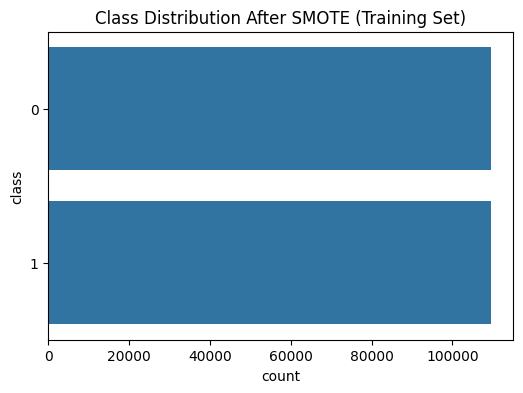

Confusion Matrix:
[[18425  8968]
 [  916  1914]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     27393
           1       0.18      0.68      0.28      2830

    accuracy                           0.67     30223
   macro avg       0.56      0.67      0.53     30223
weighted avg       0.88      0.67      0.74     30223


Precision-Recall AUC: 0.2695


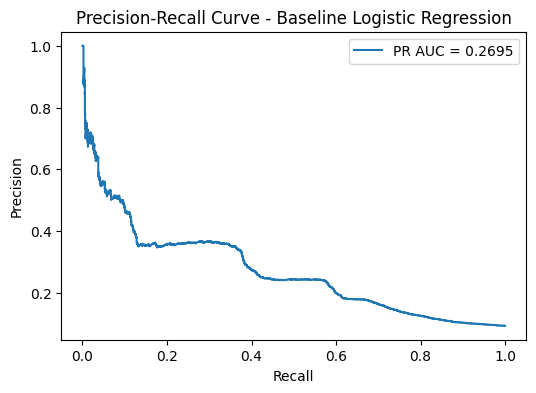

In [1]:
# ---------------------------------------------
# Task 2: Load Processed Data & Initial Baseline
# ---------------------------------------------
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed datasets
X_train = pd.read_csv("../data/processed/X_train_fraud.csv")
X_test  = pd.read_csv("../data/processed/X_test_fraud.csv")
y_train = pd.read_csv("../data/processed/y_train_fraud.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test_fraud.csv").squeeze()

# Verify class distribution after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(y=y_train)
plt.title("Class Distribution After SMOTE (Training Set)")
plt.show()

# ---------------------------------------------
# Baseline Logistic Regression
# ---------------------------------------------
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

# Predict on test set
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:,1]

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

# Plot PR Curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Logistic Regression')
plt.legend()
plt.show()
